In [9]:
from screenernet_np import train
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

from torch.utils.data import Dataset
import torch

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from dataset_generation import RegressionDataset
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock

### Constants

In [10]:
dataset_size=128
batch_size=128
context_size=64
target_size=32
num_epochs=1000
kl_penalty=1e-4
num_posterior_mc=1
rng = jax.random.key(0)
test_resolution=512

### Dataset

In [11]:
class MixtureDataset(Dataset):
    def __init__(self, dataset_size, key, num_context_samples, num_target_samples, sampler):
        self.key = key
        self.dataset_size = dataset_size
        self.num_context_samples = num_context_samples
        self.num_target_samples = num_target_samples
        self.sampler = sampler
        self.context_xs, self.target_xs, self.context_ys, self.target_ys = self._get_data()
        
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.context_xs[idx], self.context_ys[idx], self.target_xs[idx], self.target_ys[idx]

    def _get_data(self):
        key_data, self.key = jax.random.split(self.key)
        xs, ys = jax.vmap(self.sampler)(jax.random.split(key_data, num=self.dataset_size))
        xs, ys = xs[..., None], ys[..., None]
        # Split into context- and target-points.
        X, x_test = jnp.split(xs, indices_or_sections=(context_size, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(context_size, ), axis=1)
        return X, x_test, y, y_test

### Data Loader

In [12]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])
def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys
data_sampler = partial(
    joint, 
    WhiteNoise(f2, 0.1), 
    partial(uniform, n=context_size + target_size, bounds=(-1, 1))
)
def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return torch.tensor(xs_context), torch.tensor(ys_context), torch.tensor(xs_target), torch.tensor(ys_target)
rng, key = jax.random.split(rng)
dataset = MixtureDataset(dataset_size=num_epochs*batch_size, key=key, num_context_samples=context_size, num_target_samples=target_size, sampler=data_sampler)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
data_iter = iter(dataloader)

### Model initialization

In [13]:
model, params, losses=train(dataloader, dataset_size, context_size, num_epochs, rng, kl_penalty, num_posterior_mc)

Optimizing params. Losses: 16.8399 0.8235: 100%|██████████| 1000/1000 [34:36<00:00,  2.08s/it]


In [14]:
# Test predictions on functions from the training-distribution
def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise
rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))
x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)
rng, test_key = jax.random.split(rng)
key_data, key_model = jax.random.split(test_key)

x_train, y_train = data_sampler(test_key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(context_size, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(context_size, ))

# Compute ELBO over batch of datasets
# means, stds = model.apply(
#     params, 
#     X, y, x_test[..., None],
#     k=10,
#     rngs={'default': jax.random.key(0)}
# )
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


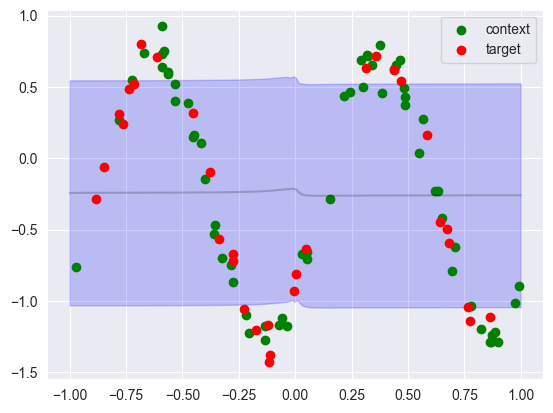

In [15]:
for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )


plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

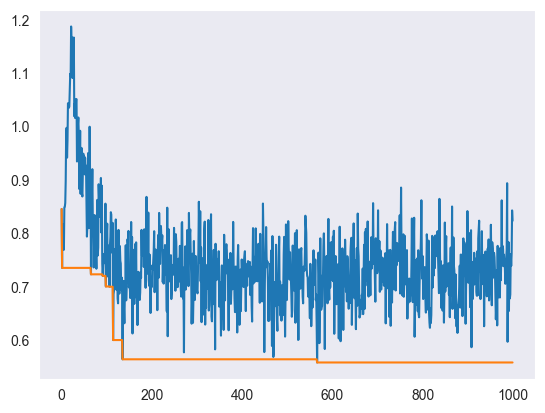

In [16]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()